In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests, csv, json, ta
from datetime import datetime, timedelta

### Get list of all active tickers from all exchanges as of date

In [203]:
def get_all_active_stocks():
    
    CSV_URL = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=TYTNO3561Z0C1XA2'

    with requests.Session() as s:
        download = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)
        df = pd.DataFrame(my_list)
        headers = df.iloc[0]
        listings = pd.DataFrame(df.values[1:], columns=headers)
        listings = listings.set_index('symbol')
    return listings
    

listings = get_all_active_stocks()

In [102]:
from yahoo_fin import stock_info as si

sp500 = pd.DataFrame( si.tickers_sp500() )
dow = pd.DataFrame( si.tickers_dow())

my_list = ['TSM']

In [103]:
tickers = set(list(dow.loc[:,0].values) + list(sp500.loc[:,0].values))
print('Total tickers are {}'.format(len(tickers)))

Total tickers are 503


In [204]:
# saving all listing as of today
listings.to_csv('listings.csv')

# saving counts by exchanges
listings[['exchange','assetType']] \
    .value_counts() \
    .reset_index(name='count') \
    .to_csv('listings_ct.csv', index=False)

# selecting tickers from NASDAQ  
tickers = list(listings[(listings['exchange'] == 'NASDAQ') & (listings['assetType'] == 'Stock')].index.values)

print('selected {0} tickers from NASDAQ'.format(len(tickers)))

selected 4809 tickers from NASDAQ


In [205]:
# Removing delete tickers from list of all tickers

tickers_del = pd.read_csv('tickers_del.csv',header=None)
tickers_del_list = list(tickers_del.iloc[:,0].values)

final_tickers = [t for t in tickers if t not in tickers_del_list]
len(final_tickers)

4711

# 1. Rocket stocks

Rocket stocks follow below trend (only works in bullish market) 
1. Hits all time highs everyday
    * At ATHs all buyers are happy
    * short sellers also will be forced to buy when ATHs hit consistently 
    * panicked buying kicks in 
2. Surge in Daily volume and stock gaps occur
    * check stocks that are trading at 4 - 40x daily averge volume
3. Stock trades above 50 day MA
4. 50 day MA > 200 day MA
5. Market cap < 4B 
6. Float is 20% or less of Total shares. 
    * Float is total available shares to trade
7. Short interest > 10% 
8. Check for bullish market - SPY trading above 50 MA and 50MA > 200 MA


### Download data for all tickers

In [11]:
# pd.set_option('display.max_rows', None)
stock_info = {}
tickers_delete = []

for stock in tickers:
    try:
        # Create a Ticker object for the stock
        ticker = yf.Ticker(stock)
        stock_info[stock] = ticker.info
    except Exception as e:
        # Handle any other exceptions
        print(f"An error occurred for {stock}: {str(e)}")
        tickers_delete.append(stock)
    
    continue

stock_info_df = pd.DataFrame(stock_info).T.convert_dtypes()
stock_info_df = stock_info_df.round(2)

In [12]:
stock_info_df

,address1,address2,city,zip,country,phone,fax,website,industry,industryDisp,...,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,financialCurrency,trailingPegRatio,state,lastSplitFactor,lastSplitDate,industrySymbol
ACN,1 Grand Canal Square,Grand Canal Harbour,Dublin,D02 P820,Ireland,353 1 646 2000,353 1 646 2020,https://www.accenture.com,Information Technology Services,Information Technology Services,...,0.02,0.32,0.17,0.15,USD,2.81,<NA>,<NA>,<NA>,<NA>
CL,300 Park Avenue,<NA>,New York,10022-7499,United States,212 310 2000,<NA>,https://www.colgatepalmolive.com,Household & Personal Products,Household & Personal Products,...,0.08,0.57,0.21,0.18,USD,2.75,NY,2:1,1368662400,<NA>
CF,4 Parkway North,Suite 400,Deerfield,60015,United States,847 405 2400,<NA>,https://www.cfindustries.com,Agricultural Inputs,Agricultural Inputs,...,-0.3,0.49,0.54,0.46,USD,<NA>,IL,5:1,1434585600,<NA>
WBA,108 Wilmot Road,<NA>,Deerfield,60015,United States,847 315 3700,<NA>,https://www.walgreensbootsalliance.com,Pharmaceutical Retailers,Pharmaceutical Retailers,...,<NA>,0.0,0.0,0.0,USD,2.57,IL,2:1,919123200,<NA>
CAH,7000 Cardinal Place,<NA>,Dublin,43017,United States,614 757 5000,<NA>,https://www.cardinalhealth.com,Medical Distribution,Medical Distribution,...,0.13,0.03,0.01,0.01,USD,5.16,OH,3:2,987984000,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GLW,One Riverfront Plaza,<NA>,Corning,14831,United States,607 974 9000,<NA>,https://www.corning.com,Electronic Components,Electronic Components,...,-0.14,0.33,0.22,0.12,USD,1.41,NY,3:1,970617600,<NA>
PFE,66 Hudson Boulevard East,<NA>,New York,10001-2192,United States,212 733 2323,<NA>,https://www.pfizer.com,Drug Manufacturers—General,Drug Manufacturers—General,...,-0.29,0.69,0.44,0.38,USD,<NA>,NY,1054:1000,1605571200,<NA>
AMZN,410 Terry Avenue North,<NA>,Seattle,98109-5210,United States,206 266 1000,<NA>,https://www.aboutamazon.com,Internet Retail,Internet Retail,...,0.09,0.45,0.11,0.03,USD,4.58,WA,20:1,1654473600,<NA>
BXP,"Prudential Center, 800 Boylston Street",Suite 1900,Boston,02199-8103,United States,(617) 236-3300,(617) 236-3311,https://www.bxp.com,REIT—Office,REIT—Office,...,0.05,0.63,0.58,0.33,USD,<NA>,MA,<NA>,<NA>,<NA>


In [244]:
#stock_info_df = stock_info_df.drop(['longBusinessSummary','companyOfficers'],axis=1)
stock_info_df.to_csv('stock_info_df.csv')

In [ ]:
stocks = pd.read_csv('stock_info_df.csv')
display(stocks)

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (10,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [209]:
# updating delete tickers

tickers_del_list = tickers_del_list + tickers_delete
pd.DataFrame(tickers_delete).to_csv('tickers_del.csv',index=False, header=False)

In [251]:
def timestamp_to_date(ts):
    try:
        date = datetime.fromtimestamp(ts).strftime('%Y-%m-%d')
    except Exception as e:
        date = datetime.strptime("9999-9-9", "%Y-%m-%d").date()
    return date
        
stock_info_df['previousMonthShortDate'] = stock_info_df['sharesShortPreviousMonthDate'].apply(lambda x: timestamp_to_date(x))
stock_info_df['floatPercent'] = (stock_info_df['floatShares']/stock_info_df['sharesOutstanding'])*100
stock_info_df['marketCap_in_B'] = stock_info_df['marketCap'] / 1000000000
stock_info_df['marketCap_lt_4B'] = np.where((stock_info_df['marketCap_in_B'].notna()) & (stock_info_df['marketCap_in_B'] <= 4), 1, 0)
stock_info_df['floatPercent_lt_20pct'] = np.where((stock_info_df['floatPercent'].notna()) & (stock_info_df['floatPercent'] <= 20),1,0)


stockInfo = stock_info_df[['sector','industry','beta','dateShortInterest','previousMonthShortDate','floatPercent','shortPercentOfFloat','marketCap_lt_4B','floatPercent_lt_20pct',]]
stockInfo['shortInterest_gt_10'] = np.where((stock_info_df['shortPercentOfFloat'].notna()) & (stockInfo['shortPercentOfFloat'] >= 10),1,0)
stockInfo['shortInterestDate'] = stockInfo['dateShortInterest'].apply(lambda x: timestamp_to_date(x))

display(stockInfo)


/var/folders/2w/0kqpwndd7394lk_g4l7487jc0000gn/T/ipykernel_6319/1684757631.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockInfo['shortInterest_gt_10'] = np.where((stock_info_df['shortPercentOfFloat'].notna()) & (stockInfo['shortPercentOfFloat'] >= 10),1,0)
/var/folders/2w/0kqpwndd7394lk_g4l7487jc0000gn/T/ipykernel_6319/1684757631.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockInfo['shortInterestDate'] = stockInfo['dateShortInterest'].apply(lambda x: timestamp_to_date(x))


,sector,industry,beta,dateShortInterest,previousMonthShortDate,floatPercent,shortPercentOfFloat,marketCap_lt_4B,floatPercent_lt_20pct,shortInterest_gt_10,shortInterestDate
AACG,Consumer Defensive,Education & Training Services,1.14,1686787200,2023-05-14,27.075701,<NA>,1,0,0,2023-06-14
AACI,Financial Services,Shell Companies,<NA>,1686787200,2023-05-14,39.827008,0.0,1,0,0,2023-06-14
AACIU,Financial Services,Shell Companies,<NA>,1686787200,2023-05-14,<NA>,<NA>,0,0,0,2023-06-14
AACIW,<NA>,<NA>,<NA>,<NA>,9999-09-09,<NA>,<NA>,0,0,0,9999-09-09
AADI,Healthcare,Biotechnology,<NA>,1686787200,2023-05-14,63.316974,0.08,1,0,0,2023-06-14
AAL,Industrials,Airlines,1.53,1686787200,2023-05-14,98.767929,0.11,0,0,0,2023-06-14
AAME,Financial Services,Insurance—Life,0.32,1686787200,2023-05-14,19.602027,0.01,1,1,0,2023-06-14
AAOI,Technology,Communication Equipment,1.3,1686787200,2023-05-14,95.001942,0.13,1,0,0,2023-06-14
AAON,Industrials,Building Products & Equipment,0.81,1686787200,2023-05-14,82.455021,0.04,0,0,0,2023-06-14
AAPL,Technology,Consumer Electronics,1.29,1686787200,2023-05-14,99.89401,0.01,0,0,0,2023-06-14


In [252]:
stockInfo.to_csv('stockInfo.csv')

In [18]:
pd.DataFrame(tickers_delete).to_csv('tickers_del.csv',index=False, header=False)

In [52]:
df = pd.DataFrame(stock_info).T

In [54]:
df.to_csv('stock_info.csv')

In [127]:
tickers = ['GOOGL']

In [ ]:
import requests, nltk
from nltk.sentiment import SentimentIntensityAnalyzer


def sentiment_analysis(symbol):

    # Fetch StockTwits messages for the stock symbol
    url = f"https://api.stocktwits.com/api/2/streams/symbol/{symbol}.json?limit={limit}"
    response = requests.get(url)
    data = response.json()

    # Extract messages from the response
    messages = [msg['body'] for msg in data['messages']]

    # Initialize the Sentiment Intensity Analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis on each message
    sentiments = []
    for message in messages:
        sentiment_score = sia.polarity_scores(message)
        sentiment = 'Positive' if sentiment_score['compound'] >= 0 else 'Negative'
        sentiments.append(sentiment)

    # Count the number of positive and negative sentiments
    positive_count = sentiments.count('Positive')
    negative_count = sentiments.count('Negative')
    
    return (positive_count/len(messages))*100


In [140]:
from pandas_datareader import data
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import SMAIndicator, MACD

stock_data_df = pd.DataFrame()
stock_rsi_df = pd.DataFrame()

for stock in tickers:
    end_date = datetime.now()
    start_date = end_date - timedelta(days=2*365)
    stock_data = yf.download(tickers=stock, start=start_date, end=end_date, interval='1d')
    stock_data['Ticker'] = stock
        
    # shift by 1 to get previous close and volumes
    stock_data['prev_Close'] = stock_data.loc[:, 'Close'].shift(1)
    stock_data['prev_Volume'] = stock_data.loc[:, 'Volume'].shift(1)

    # 50,200 SMAs
    stock_data['50SMA'] = stock_data['Close'].rolling(50).mean()
    stock_data['200SMA'] = stock_data['Close'].rolling(200).mean()

    # 50 day avg volume
    stock_data['50SMA_vol'] = stock_data['prev_Volume'].rolling(50).mean()

    # Bollinger bands
    indicator_bb = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
    stock_data["bb_upperband"] = indicator_bb.bollinger_hband()
    stock_data["bb_lowerband"] = indicator_bb.bollinger_lband()
    stock_data['bb_lb_cross'] = indicator_bb.bollinger_lband_indicator()
    stock_data['bb_ub_cross'] = indicator_bb.bollinger_hband_indicator()
    
    # MACD
    macd = MACD(close=stock_data["Close"],window_slow=26,window_fast=12,window_sign=9)
    stock_data['macd_line'] = macd.macd()
    stock_data['macd_hist'] = macd.macd_diff()
    stock_data['macd_signal'] = macd.macd_signal()
    
    stock_data['macd_trend'] = np.where(stock_data['macd_hist'] > 0, 'Uptrend', 'Downtrend')
    stock_data['macd_trend_reversal'] = stock_data['macd_trend'].ne(stock_data['macd_trend'].shift())
    
    stock_data['uptrend_days'] = 0
    stock_data['downtrend_days'] = 0

    uptrend_count = 0
    downtrend_count = 0

    for i, row in stock_data.iterrows():
        if row['macd_trend_reversal']:
            uptrend_count = 0
            downtrend_count = 0

        if row['macd_trend'] == 'Uptrend':
            uptrend_count += 1
            stock_data.at[i, 'uptrend_days'] = uptrend_count
        elif row['macd_trend'] == 'Downtrend':
            downtrend_count += 1
            stock_data.at[i, 'downtrend_days'] = downtrend_count
    
    #ROC
#     stock_data['roc_monthly'] = ROCIndicator(stock_data['Close'], window=21).roc()
#     stock_data['roc_qrtr'] = ROCIndicator(stock_data['Close'], window=63).roc()
#     stock_data['roc_semi'] = ROCIndicator(stock_data['Close'], window=125).roc()
#     stock_data['roc_yr'] = ROCIndicator(stock_data['Close'], window=252).roc()

    stock_data['roc'] = (ROCIndicator(stock_data['Close'], window=21).roc() + ROCIndicator(stock_data['Close'], window=63).roc() +
                        ROCIndicator(stock_data['Close'], window=125).roc() + ROCIndicator(stock_data['Close'], window=252).roc())
    
    roc_percentiles = stock_data['roc'].quantile([0.01,0.05,0.1, 0.9,0.95,0.99]).T
    roc_oversold = roc_percentiles.loc[0.01]
    roc_overbought = roc_percentiles.loc[0.99]

    # print(roc_percentiles)
    stock_data['roc_buy_signal'] = ((stock_data['roc'] < roc_oversold) & (stock_data['roc'].shift(1) >= roc_oversold))
    stock_data['roc_sell_signal'] = ((stock_data['roc'] > roc_overbought) & (stock_data['roc'].shift(1) <= roc_overbought))

    
    #RSI
    rsi = RSIIndicator(close=stock_data["Close"])
    stock_data['rsi'] = rsi.rsi()
    rsi_percentiles = stock_data['rsi'].quantile([0.01,0.05,0.1, 0.9,0.95,0.99]).T
    stock_rsi_df[stock] = rsi_percentiles
    
    # print(rsi_percentiles)
    # Get dynamic oversold and overbought levels
    rsi_oversold = rsi_percentiles.loc[0.05]
    rsi_overbought = rsi_percentiles.loc[0.95]
    
    stock_data['rsi_buy_signal'] = ((stock_data['rsi'] < rsi_oversold) & (stock_data['rsi'].shift(1) >= rsi_oversold))
    stock_data['rsi_sell_signal'] = ((stock_data['rsi'] > rsi_overbought) & (stock_data['rsi'].shift(1) <= rsi_overbought))
    

    # Volume surge indicator
    stock_data['volChange'] = (stock_data['Volume']/stock_data['50SMA_vol']).round(2)
    stock_data['volSurgeInd'] = np.where(stock_data['Volume']/stock_data['50SMA_vol'] > 4, 1, 0)
    
    # 52 week high & low
    stock_data['is52wkHigh'] = np.where(stock_data['Close'] >= stock_data['Close'].rolling(window=252).max(),1, 0)
    stock_data['is52wkLow'] = np.where(stock_data['Close'] <= stock_data['Close'].rolling(window=252).min(),1, 0)
    
    stock_data['50gt200'] = np.where(stock_data['50SMA'] >= stock_data['200SMA'], 1, 0)
    # stock_data['50gt200Prev'] = stock_data.loc[:,'50gt200'].astype('int').shift(1)
    
    stock_data['tradingabv50SMA'] = np.where(stock_data['Close'] > stock_data['50SMA'],1,0)
    # stock_data['tradingabv50SMAtrend'] = stock_data['tradingabv50SMA'].rolling(window=252).sum()
    # stock_data['50gt200trend'] = stock_data['50gt200'].rolling(window=252).sum()
    
    # stock gap
    stock_data['gap_pct'] = round(((stock_data['Close'] - stock_data['prev_Close'])/stock_data['prev_Close'])*100,2)
    
    stock_data = stock_data.dropna()
    stock_data = stock_data.round(2)
    
    stock_data_df = stock_data_df.append(stock_data)
    
    
# display(stock_data_df.sort_values(['Ticker','Date'], ascending=False))
stock_data_df.sort_values(['Ticker','Date']).to_csv('stock_data_GOOGL.csv')
    

[*********************100%***********************]  1 of 1 completed


In [141]:
stock_rsi_df

,GOOGL
0.01,29.470665
0.05,34.339728
0.10,36.707881
0.90,67.412374
0.95,71.144728
0.99,77.336694


In [130]:
display(stock_rsi_df)

,GOOGL
0.01,29.470665
0.05,34.339728
0.10,36.707881
0.90,67.412374
0.95,71.144728
0.99,77.336694


In [138]:
stock_data_df.loc[['2023-05-26','2023-05-30','2023-05-31','2023-06-01'],:].T

Date,2023-05-26,2023-05-30,2023-05-31,2023-06-01
Open,123.17,125.64,122.75,122.82
High,125.26,125.66,124.06,124.42
Low,122.45,122.0,122.5,122.62
Close,124.61,123.67,122.87,123.72
Adj Close,124.61,123.67,122.87,123.72
Volume,35635900,35076700,37325800,30772700
Ticker,GOOGL,GOOGL,GOOGL,GOOGL
prev_Close,123.48,124.61,123.67,122.87
prev_Volume,42317000.0,35635900.0,35076700.0,37325800.0
50SMA,108.97,109.41,109.84,110.22


<AxesSubplot:xlabel='Date'>

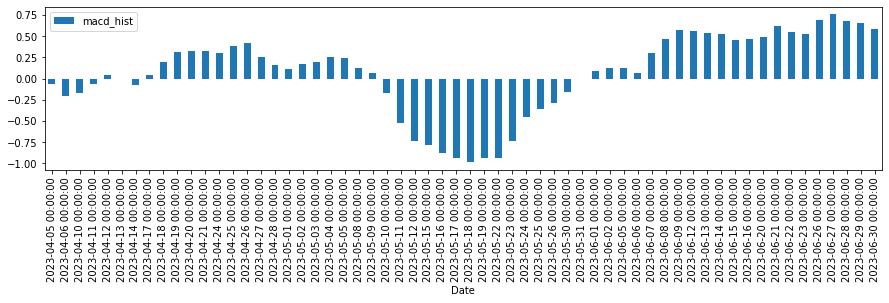

In [50]:
stock_data_df.sort_values(['Ticker','Date']).iloc[-60:,:].reset_index()[["Date", "macd_hist"]].plot(x="Date", kind="bar",figsize=(15,3))

In [24]:
display(stock_data_df)

,Open,High,Low,Close,Adj Close,Volume,Ticker,prev_Close,prev_Volume,50SMA,...,is52wkHigh,is52wkLow,50gt200,50gt200Prev,trendReversal,tradingabv50SMA,tradingabv50SMAtrend,50gt200trend,gapDollarAmt,stockGapInd
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,107.93,109.25,106.73,108.74,108.74,35476000,GOOGL,NaN,NaN,NaN,...,0,0,0,NaN,1,0,NaN,NaN,NaN,0
2022-07-05,107.10,113.38,105.73,113.26,113.26,39342000,GOOGL,108.74,35476000.0,NaN,...,0,0,0,0.0,0,0,NaN,NaN,4.53,1
2022-07-06,113.30,115.59,111.48,114.57,114.57,37432000,GOOGL,113.26,39342000.0,NaN,...,0,0,0,0.0,0,0,NaN,NaN,1.31,1
2022-07-07,115.08,119.19,114.83,118.78,118.78,40936000,GOOGL,114.57,37432000.0,NaN,...,0,0,0,0.0,0,0,NaN,NaN,4.21,1
2022-07-08,117.25,119.68,116.90,119.35,119.35,38238000,GOOGL,118.78,40936000.0,NaN,...,0,0,0,0.0,0,0,NaN,NaN,0.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,120.76,122.00,118.27,118.34,118.34,33969900,GOOGL,122.34,34885300.0,116.26,...,0,0,1,1.0,0,1,NaN,NaN,-4.00,0
2023-06-27,117.08,119.08,116.10,118.33,118.33,39535900,GOOGL,118.34,33969900.0,116.45,...,0,0,1,1.0,0,1,NaN,NaN,-0.01,0
2023-06-28,117.09,120.39,116.85,120.18,120.18,27091400,GOOGL,118.33,39535900.0,116.74,...,0,0,1,1.0,0,1,NaN,NaN,1.85,1


In [72]:
stock_data_df.dtypes

Open                    float64
High                    float64
Low                     float64
Close                   float64
Adj Close               float64
Volume                    int64
Ticker                   object
prev_Close              float64
prev_Volume             float64
50SMA                   float64
200SMA                  float64
50SMA_vol               float64
bb_upperband            float64
bb_lowerband            float64
bb_lb_cross               int64
bb_ub_cross               int64
volChange               float64
volInc                    int64
volSurgeInd               int64
is52wkHigh                int64
is52wkLow                 int64
50gt200                   int64
50gt200Prev             float64
trendReversal             int64
tradingabv50SMA           int64
tradingabv50SMAtrend    float64
50gt200trend            float64
dtype: object

In [26]:
display(stock_data_df.sort_values(['Date'], ascending=False))

KeyError: 'Date'

In [37]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

api_key = "TYTNO3561Z0C1XA2"  
# Use the TimeSeries class from the alpha_vantage library to retrieve real-time data:
# Create an instance of the TimeSeries class
ts = TimeSeries(key=api_key, output_format='pandas')

# Get the real-time stock quote
symbol = "AAPL"
data, metadata = ts.get_quote_endpoint(symbol)

# Print the real-time data
print(data)

             01. symbol  02. open  03. high   04. low 05. price 06. volume  \
Global Quote       AAPL  184.4100  186.1000  184.4100  185.0100   48964426   

             07. latest trading day 08. previous close 09. change  \
Global Quote             2023-06-20           184.9200     0.0900   

             10. change percent  
Global Quote            0.0487%  


In [64]:

ts = TimeSeries(key=api_key, output_format='json')
ti = TechIndicators(key=api_key, output_format='pandas')

# Get the real-time stock quote
symbol = "NVDA"
data, metadata = ti.get_sma(symbol, interval='daily', time_period=200, series_type='close')

# data, metadata = ti.get_technical_indicator(symbol, interval='daily')

print(data)
moving_average = data['2023-06-16']

# Print the real-time data
# print("200-day Moving Average:", moving_average)

                 SMA
date                
2000-08-15    1.5550
2000-08-16    1.5667
2000-08-17    1.5785
2000-08-18    1.5906
2000-08-21    1.6028
...              ...
2023-06-13  207.7590
2023-06-14  209.0965
2023-06-15  210.4397
2023-06-16  211.8016
2023-06-20  213.2379

[5747 rows x 1 columns]


KeyError: '2023-06-16'

In [33]:
end_date = datetime.now()
end_date

datetime.datetime(2023, 6, 20, 18, 5, 40, 77602)

In [19]:
url = 'https://www.alphavantage.co/query?function=MARKET_STATUS&apikey=TYTNO3561Z0C1XA2'
response = requests.get(url)
data = json.loads(response.text)
markets = pd.json_normalize(data['markets'])

display(markets)

In [21]:
listings[['exchange','assetType']] \
    .value_counts() \
    .reset_index(name='count') \
#    .to_csv('listings_ct.csv', index=False)

In [54]:
ts = TimeSeries(key=api_key, output_format='pandas')

# Get all available technical indicators
symbol = "NVDA"  # Replace with the desired stock symbol
data, metadata = ts.get_batch_stock_quotes(symbols=symbol)

AttributeError: 'TimeSeries' object has no attribute 'get_batch_stock_quotes'

In [6]:

import requests
import pandas as pd
from bs4 import BeautifulSoup

# Get the webpage
url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001045810&type=10-K&dateb=&owner=exclude&count=40'
response = requests.get(url)

# Load the webpage content
soup = BeautifulSoup(response.content, 'html.parser')
print(soup.prettify())

# Get the table having the filings data
table = soup.find('table', {'class': 'tableFile2'}) 

# Get all the rows of table
rows = table.find_all('tr') # find error here         

# Get the columns from the table
columns = [v.text.replace('\n', '') for v in rows[0].find_all('th')]
columns


# Initialize the dataframe with the columns
df = pd.DataFrame(columns=columns)


# Get all the table rows
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    # Get all the table data
    data = [td.text.replace('\n', '').strip() for td in tds]
    
    # Append the data to the dataframe
    df = df.append(pd.Series(data=data, index=columns), ignore_index=True)

# Display the dataframe
print(df)

# Get the link to the XBRL instance document
instance_document = 'https://www.sec.gov/Archives/' + df['Filings'].iloc[0]

# Get the XBRL instance document
xbrl_response = requests.get(instance_document)

# Load the XBRL instance document
xbrl_response_content = BeautifulSoup(xbrl_response.content, 'lxml')

# Find and print stockholder's equity
stockholder_equity = xbrl_response_content.find('us-gaap:stockholdersequity')

print(stockholder_equity)

# Find and print the common stock value
common_stock = xbrl_response_content.find('us-gaap:commonstockvalue')

print(common_stock)

# Find and print the retained earnings value
retained_earnings = xbrl_response_content.find('us-gaap:retainedearningsdeficit')

print(retained_earnings)


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   SEC.gov | Request Rate Threshold Exceeded
  </title>
  <style>
   html {height: 100%}
body {height: 100%; margin:0; padding:0;}
#header {background-color:#003968; color:#fff; padding:15px 20px 10px 20px;font-family:Arial, Helvetica, sans-serif; font-size:20px; border-bottom:solid 5px #000;}
#footer {background-color:#003968; color:#fff; padding:15px 20px;font-family:Arial, Helvetica, sans-serif; font-size:20px;}
#content {max-width:650px;margin:60px auto; padding:0 20px 100px 20px; background-image:url(seal_bw.png);background-repeat:no-repeat;background-position:50% 100%;}
h1 {font-family:Georgia, Times, serif; font-size:20px;}
h2 {text-align:center; font-family:Georgia, Times, serif; font-size:20px; width:100%; border-bottom:solid 

AttributeError: 'NoneType' object has no attribute 'find_all'

In [27]:
data = {
	'address1': '2788 San Tomas Expressway',
	'city': 'Santa Clara',
	'state': 'CA',
	'zip': '95051',
	'country': 'United States',
	'phone': '408 486 2000',
	'website': 'https://www.nvidia.com',
	'industry': 'Semiconductors',
	'industryDisp': 'Semiconductors',
	'sector': 'Technology',
	'longBusinessSummary': "NVIDIA Corporation provides graphics, and compute and networking solutions in the United States, Taiwan, China, and internationally. The company's Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building 3D designs and virtual worlds. Its Compute & Networking segment provides Data Center platforms and systems for AI, HPC, and accelerated computing; Mellanox networking and interconnect solutions; automotive AI Cockpit, autonomous driving development agreements, and autonomous vehicle solutions; cryptocurrency mining processors; Jetson for robotics and other embedded platforms; and NVIDIA AI Enterprise and other software. The company's products are used in gaming, professional visualization, datacenter, and automotive markets. NVIDIA Corporation sells its products to original equipment manufacturers, original device manufacturers, system builders, add-in board manufacturers, retailers/distributors, independent software vendors, Internet and cloud service providers, automotive manufacturers and tier-1 automotive suppliers, mapping companies, start-ups, and other ecosystem participants. It has a strategic collaboration with Kroger Co. NVIDIA Corporation was incorporated in 1993 and is headquartered in Santa Clara, California.",
	'fullTimeEmployees': 26196,
	'companyOfficers': [{
		'maxAge': 1,
		'name': 'Mr. Jen-Hsun  Huang',
		'age': 59,
		'title': 'Co-Founder, CEO, Pres & Director',
		'yearBorn': 1963,
		'fiscalYear': 2023,
		'totalPay': 1690542,
		'exercisedValue': 442805504,
		'unexercisedValue': 94833752
	}, {
		'maxAge': 1,
		'name': 'Ms. Colette M. Kress',
		'age': 55,
		'title': 'Exec. VP & CFO',
		'yearBorn': 1967,
		'fiscalYear': 2023,
		'totalPay': 912551,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Ms. Debora  Shoquist',
		'age': 67,
		'title': 'Exec. VP of Operations',
		'yearBorn': 1955,
		'fiscalYear': 2023,
		'totalPay': 870785,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Mr. Timothy S. Teter',
		'age': 55,
		'title': 'Exec. VP, Gen. Counsel & Sec.',
		'yearBorn': 1967,
		'fiscalYear': 2023,
		'totalPay': 862709,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Mr. Ajay K. Puri',
		'age': 67,
		'title': 'Exec. VP of Worldwide Field Operations',
		'yearBorn': 1955,
		'fiscalYear': 2023,
		'totalPay': 993707,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Mr. Chris A. Malachowsky',
		'title': 'Co-Founder',
		'fiscalYear': 2002,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Mr. Donald F. Robertson Jr.',
		'age': 53,
		'title': 'VP & Chief Accounting Officer',
		'yearBorn': 1969,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Prof. William J. Dally',
		'age': 61,
		'title': 'Chief Scientist & Sr. VP of Research',
		'yearBorn': 1961,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Ms. Simona  Jankowski C.F.A., J.D.',
		'title': 'VP of Investor Relations',
		'exercisedValue': 0,
		'unexercisedValue': 0
	}, {
		'maxAge': 1,
		'name': 'Mr. Robert  Sherbin',
		'age': 63,
		'title': 'VP of Corp. Communications',
		'yearBorn': 1959,
		'exercisedValue': 0,
		'unexercisedValue': 0
	}],
	'auditRisk': 5,
	'boardRisk': 9,
	'compensationRisk': 1,
	'shareHolderRightsRisk': 8,
	'overallRisk': 7,
	'governanceEpochDate': 1685577600,
	'compensationAsOfEpochDate': 1703980800,
	'maxAge': 86400,
	'priceHint': 2,
	'previousClose': 430.45,
	'open': 422.53,
	'dayLow': 422.34,
	'dayHigh': 434.255,
	'regularMarketPreviousClose': 430.45,
	'regularMarketOpen': 422.53,
	'regularMarketDayLow': 422.34,
	'regularMarketDayHigh': 434.255,
	'dividendRate': 0.16,
	'dividendYield': 0.0004,
	'exDividendDate': 1686096000,
	'payoutRatio': 0.0833,
	'fiveYearAvgDividendYield': 0.18,
	'beta': 1.751408,
	'trailingPE': 222.92746,
	'forwardPE': 41.4499,
	'volume': 41655746,
	'regularMarketVolume': 41655746,
	'averageVolume': 47002012,
	'averageVolume10days': 52304250,
	'averageDailyVolume10Day': 52304250,
	'bid': 0.0,
	'ask': 0.0,
	'bidSize': 1100,
	'askSize': 1300,
	'marketCap': 1062717554688,
	'fiftyTwoWeekLow': 108.13,
	'fiftyTwoWeekHigh': 439.9,
	'priceToSalesTrailing12Months': 41.06645,
	'fiftyDayAverage': 329.0804,
	'twoHundredDayAverage': 216.2112,
	'trailingAnnualDividendRate': 0.16,
	'trailingAnnualDividendYield': 0.00037170402,
	'currency': 'USD',
	'enterpriseValue': 1059971530752,
	'profitMargins': 0.18521,
	'floatShares': 2371027100,
	'sharesOutstanding': 2470000128,
	'sharesShort': 26884245,
	'sharesShortPriorMonth': 32599217,
	'sharesShortPreviousMonthDate': 1682640000,
	'dateShortInterest': 1685491200,
	'sharesPercentSharesOut': 0.0109,
	'heldPercentInsiders': 0.041810002,
	'heldPercentInstitutions': 0.68084,
	'shortRatio': 0.51,
	'shortPercentOfFloat': 0.0113,
	'impliedSharesOutstanding': 2470000128,
	'bookValue': 9.915,
	'priceToBook': 43.39385,
	'lastFiscalYearEnd': 1674950400,
	'nextFiscalYearEnd': 1706486400,
	'mostRecentQuarter': 1682812800,
	'earningsQuarterlyGrowth': 0.263,
	'netIncomeToCommon': 4792999936,
	'trailingEps': 1.93,
	'forwardEps': 10.38,
	'pegRatio': 2.61,
	'lastSplitFactor': '4:1',
	'lastSplitDate': 1626739200,
	'enterpriseToRevenue': 40.96,
	'enterpriseToEbitda': 174.051,
	'52WeekChange': 1.5122621,
	'SandP52WeekChange': 0.12018943,
	'lastDividendValue': 0.04,
	'lastDividendDate': 1686096000,
	'exchange': 'NMS',
	'quoteType': 'EQUITY',
	'symbol': 'NVDA',
	'underlyingSymbol': 'NVDA',
	'shortName': 'NVIDIA Corporation',
	'longName': 'NVIDIA Corporation',
	'firstTradeDateEpochUtc': 917015400,
	'timeZoneFullName': 'America/New_York',
	'timeZoneShortName': 'EDT',
	'uuid': '7f5f6a07-b148-30f4-98a2-2caa3df2aed0',
	'messageBoardId': 'finmb_32307',
	'gmtOffSetMilliseconds': -14400000,
	'currentPrice': 430.25,
	'targetHighPrice': 710.0,
	'targetLowPrice': 244.8,
	'targetMeanPrice': 467.95,
	'targetMedianPrice': 462.0,
	'recommendationMean': 1.9,
	'recommendationKey': 'buy',
	'numberOfAnalystOpinions': 40,
	'totalCash': 15320000512,
	'totalCashPerShare': 6.202,
	'ebitda': 6089999872,
	'totalDebt': 12080000000,
	'quickRatio': 2.672,
	'currentRatio': 3.427,
	'totalRevenue': 25877999616,
	'debtToEquity': 49.266,
	'revenuePerShare': 10.443,
	'returnOnAssets': 0.06267,
	'returnOnEquity': 0.18855,
	'grossProfits': 15356000000,
	'freeCashflow': 5470499840,
	'operatingCashflow': 6821000192,
	'earningsGrowth': 0.281,
	'revenueGrowth': -0.132,
	'grossMargins': 0.56314,
	'ebitdaMargins': 0.23534,
	'operatingMargins': 0.17374,
	'financialCurrency': 'USD',
	'trailingPegRatio': 2.4458
}

In [32]:
del data['companyOfficers']
df = pd.DataFrame.from_dict(data)

KeyError: 'companyOfficers'

In [33]:
df = pd.DataFrame.from_dict(data)

ValueError: If using all scalar values, you must pass an index

In [35]:
df['companyOfficers']

0    {'maxAge': 1, 'name': 'Mr. Jen-Hsun  Huang', '...
1    {'maxAge': 1, 'name': 'Ms. Colette M. Kress', ...
2    {'maxAge': 1, 'name': 'Ms. Debora  Shoquist', ...
3    {'maxAge': 1, 'name': 'Mr. Timothy S. Teter', ...
4    {'maxAge': 1, 'name': 'Mr. Ajay K. Puri', 'age...
5    {'maxAge': 1, 'name': 'Mr. Chris A. Malachowsk...
6    {'maxAge': 1, 'name': 'Mr. Donald F. Robertson...
7    {'maxAge': 1, 'name': 'Prof. William J. Dally'...
8    {'maxAge': 1, 'name': 'Ms. Simona  Jankowski C...
9    {'maxAge': 1, 'name': 'Mr. Robert  Sherbin', '...
Name: companyOfficers, dtype: object